In [ ]:
import os
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DQN, A2C, PPO, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.logger import configure
from gymnasium.wrappers import FlattenObservation
import highway_env
import numpy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

lidarconfig = {
    "observation": {
        "type": "LidarObservation",
    }
}

greyscaleconfig = {
    "observation": {
        "type": "GrayscaleObservation",
        "observation_shape": (128, 64),
        "stack_size": 4,
        "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
        "scaling": 1.75,
    },
    "policy_frequency": 2
}

lidar_env = gym.make("intersection-v0", config=lidarconfig)
greyscale_env = gym.make("intersection-v0", config=greyscaleconfig)

lidar_model_file = "PPO/lidarmodel"
untuned_lidar_model_file = "PPO/untuned_lidarmodel"
greyscale_model_file = "PPO/greyscalemodel"
untuned_greyscale_model_file = "PPO/untuned_greyscalemodel"

print(f"Created environment")

#model = PPO.load(model_file, env=env)

top_config_lidar = {'learning_rate': 2.6758482108853683e-05, 
                    'gamma': 0.9583328444423079, 
                    'gae_lambda': 0.8692127415671045,
                    'clip_range': 0.10452104128583364, 
                    'ent_coef': 0.00010331741238967284}

model_lidar = PPO(
    policy="MlpPolicy",
    env=lidar_env,
    learning_rate=top_config_lidar['learning_rate'],
    gamma=top_config_lidar['gamma'],
    gae_lambda=top_config_lidar['gae_lambda'],
    clip_range=top_config_lidar['clip_range'],
    ent_coef=top_config_lidar['ent_coef'],
    verbose=1,
    tensorboard_log="./tensorboard_data/"
)

top_config_greyscale = {'learning_rate': 0.00016047865577288476, 
              'gamma': 0.9972333738718513, 
              'gae_lambda': 0.8591662103998138, 
              'clip_range': 0.29561000733453685, 
              'ent_coef': 0.0007472898347021409}

model_grey = PPO(
    policy="MlpPolicy",
    env=greyscale_env,
    learning_rate=top_config_greyscale['learning_rate'],
    gamma=top_config_greyscale['gamma'],
    gae_lambda=top_config_greyscale['gae_lambda'],
    clip_range=top_config_greyscale['clip_range'],
    ent_coef=top_config_greyscale['ent_coef'],
    verbose=1,
    tensorboard_log="./tensorboard_data/"
)


c:\Users\Sidd\Desktop\SJSU\F2025\Learning\CS 272\Autonomous-Driving\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
c:\Users\Sidd\Desktop\SJSU\F2025\Learning\CS 272\Autonomous-Driving\.venv\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Created environment
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:
class RewardTracker(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.current_ep_reward = 0

    def _on_step(self):
        # infos is a list of info dicts when using vectorized envs
        info = self.locals.get("infos", [{}])[0]
        reward = self.locals["rewards"][0]
        self.current_ep_reward += reward

        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.current_ep_reward)
            self.current_ep_reward = 0
        return True

## Tuned Lidar Model (100k timesteps)

In [4]:
lidar_cb = RewardTracker()

model_lidar.learn(total_timesteps=100_000, callback=lidar_cb, tb_log_name="PPO_lidar_tuned")
print(f"Tuned Lidar Model finished learning")
lidar_rewards = np.array(lidar_cb.episode_rewards)

model_lidar.save(lidar_model_file)

Logging to ./ppo_tensorboard/PPO_lidar_tuned_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.91     |
|    ep_rew_mean     | 1.38     |
| time/              |          |
|    fps             | 35       |
|    iterations      | 1        |
|    time_elapsed    | 56       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.8          |
|    ep_rew_mean          | 1.65         |
| time/                   |              |
|    fps                  | 35           |
|    iterations           | 2            |
|    time_elapsed         | 115          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037648217 |
|    clip_fraction        | 0.167        |
|    clip_range           | 0.105        |
|    entropy_loss         | -1.1         |
|    explai

## Default Lidar

In [ ]:
lidar_cb_untuned = RewardTracker()

untuned_lidar = PPO(
    policy="MlpPolicy",
    env=lidar_env,
    verbose=1,
    tensorboard_log="./tensorboard_data/"
)

untuned_lidar.learn(total_timesteps=100_000, callback=lidar_cb_untuned, tb_log_name="PPO_lidar_untuned")
print(f"Default Lidar Model finished learning")
lidar_rewards_untuned = np.array(lidar_cb_untuned.episode_rewards)

untuned_lidar.save(untuned_lidar_model_file)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tensorboard/PPO_lidar_untuned_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.8      |
|    ep_rew_mean     | 0.718    |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 64       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.5         |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 129         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013222008 |
|    clip_fraction        | 0.245       |
|    clip_ran

## Tuned Greyscale Model (100k timesteps)

In [6]:
greyscale_cb = RewardTracker()

model_grey.learn(total_timesteps=100_000, callback=greyscale_cb, tb_log_name="PPO_greyscale_tuned")
print(f"Tuned GreyScale Model finished learning")
greyscale_rewards = np.array(greyscale_cb.episode_rewards)

model_grey.save(greyscale_model_file)

Logging to ./ppo_tensorboard/PPO_greyscale_tuned_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 3.03     |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 65       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 18.8       |
|    ep_rew_mean          | 6.36       |
| time/                   |            |
|    fps                  | 30         |
|    iterations           | 2          |
|    time_elapsed         | 133        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03569258 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.296      |
|    entropy_loss         | -1.07      |
|    explained_variance   | -0.0084

## Default Greyscale Model (100k timesteps)

In [ ]:
greyscale_cb_untuned = RewardTracker()

untuned_grey = PPO(
    policy="MlpPolicy",
    env=greyscale_env,
    verbose=1,
    tensorboard_log="./tensorboard_data/"
)

untuned_grey.learn(total_timesteps=100_000, callback=greyscale_cb_untuned, tb_log_name="PPO_greyscale_untuned")
print(f"Default GreyScale Model finished learning")
greyscale_rewards_untuned = np.array(greyscale_cb_untuned.episode_rewards)

untuned_grey.save(untuned_greyscale_model_file)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tensorboard/PPO_greyscale_untuned_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 3.76     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 62       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.4        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 129         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018752739 |
|    clip_fraction        | 0.295       |
|    clip

## Plot difference in Tuned v Untuned Lidar

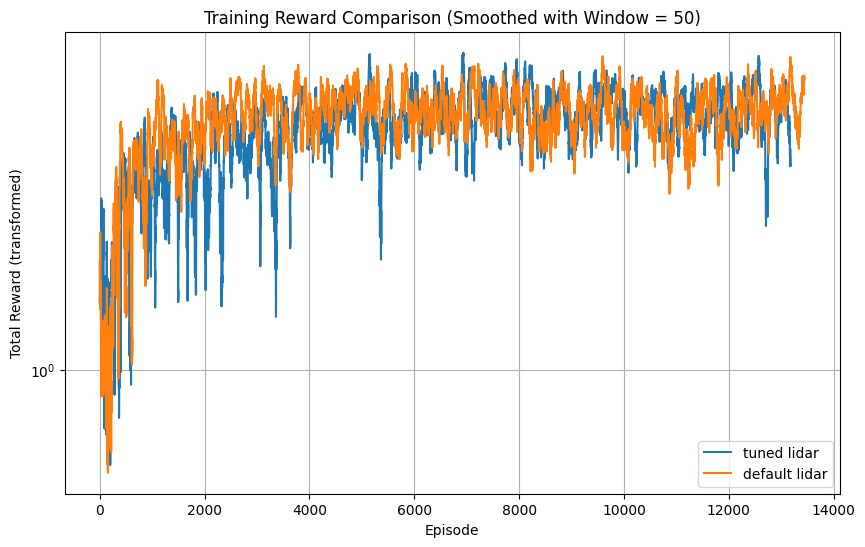

In [8]:
plt.figure(figsize=(10, 6))

# Create sliding window averages for smoother curves
window_size = 50

lidar_rewards_copy = lidar_rewards.copy()
lidar_rewards_untuned_copy = lidar_rewards_untuned.copy()

lidar_rewards_copy = np.convolve(lidar_rewards_copy, np.ones(window_size)/window_size, mode='valid')
lidar_rewards_untuned_copy = np.convolve(lidar_rewards_untuned_copy, np.ones(window_size)/window_size, mode='valid')

# # log transform to better visualize differences

# warm_rewards_copy = -1 * np.log(-1 * warm_rewards_copy + 1e-8)
# no_warm_rewards_copy = -1 * np.log(-1 * no_warm_rewards_copy + 1e-8)

plt.plot(lidar_rewards_copy, label="tuned lidar")
plt.plot(lidar_rewards_untuned_copy, label="default lidar")
plt.xlabel("Episode")
plt.ylabel("Total Reward (transformed)")
plt.yscale("symlog")
plt.title("Training Reward Comparison (Smoothed with Window = 50)")
plt.legend()
plt.grid(True)
plt.show()

## Plot difference in Tuned v Untuned Greyscale

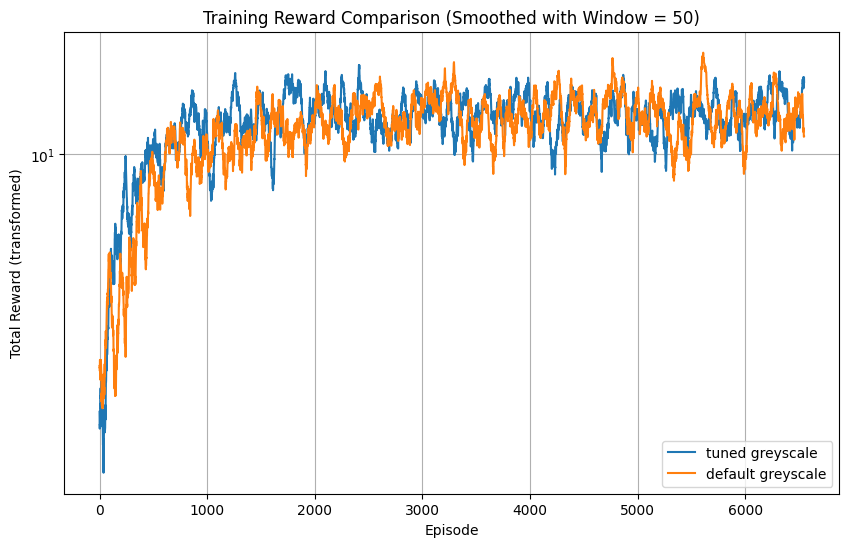

In [9]:
plt.figure(figsize=(10, 6))

# Create sliding window averages for smoother curves
window_size = 50

greyscale_rewards_copy = greyscale_rewards.copy()
greyscale_rewards_untuned_copy = greyscale_rewards_untuned.copy()

greyscale_rewards_copy = np.convolve(greyscale_rewards_copy, np.ones(window_size)/window_size, mode='valid')
greyscale_rewards_untuned_copy = np.convolve(greyscale_rewards_untuned_copy, np.ones(window_size)/window_size, mode='valid')

# # log transform to better visualize differences

# warm_rewards_copy = -1 * np.log(-1 * warm_rewards_copy + 1e-8)
# no_warm_rewards_copy = -1 * np.log(-1 * no_warm_rewards_copy + 1e-8)

plt.plot(greyscale_rewards_copy, label="tuned greyscale")
plt.plot(greyscale_rewards_untuned_copy, label="default greyscale")
plt.xlabel("Episode")
plt.ylabel("Total Reward (transformed)")
plt.yscale("symlog")
plt.title("Training Reward Comparison (Smoothed with Window = 50)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# save all model rewards to csv 
import pandas as pd
rewards_dict = {
    "tuned_lidar": lidar_rewards,
    "default_lidar": lidar_rewards_untuned,
    "tuned_greyscale": greyscale_rewards,
    "default_greyscale": greyscale_rewards_untuned
}
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in rewards_dict.items()]))
df.to_csv("model_rewards.csv", index=False)

In [ ]:
import subprocess, time, webbrowser

LOGDIR = "tensorboard_data/PPO_greyscale_tuned_1/"
PORT = 6006

# start tensorboard as a background process
tb = subprocess.Popen(
    ["tensorboard", "--logdir", LOGDIR, "--port", str(PORT)],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

# give TensorBoard time to start
time.sleep(3)

# open browser tab
webbrowser.open(f"http://localhost:{PORT}")


True

In [15]:

tb.terminate()

## Train some default DQN models for 100k timesteps to compare

In [16]:
model_DQN_lidar = DQN(
    policy="MlpPolicy",
    env=lidar_env,
    verbose=1,
    tensorboard_log="./tensorboard_data"
)

DQN_lidar_file = "DQN/dqn_lidarmodel_intersection"

model_DQN_greyscale = DQN(
    policy="MlpPolicy",
    env=greyscale_env,
    verbose=1, 
    tensorboard_log="./tensorboard_data"
)

DQN_greyscale_file = "DQN/dqn_greyscalemodel_intersection"

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Sidd\Desktop\SJSU\F2025\Learning\CS 272\Autonomous-Driving\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 65.55GB > 42.51GB
  warnings.warn(


In [18]:
dqn_lidar = RewardTracker()

model_DQN_lidar.learn(total_timesteps=100_000, callback=dqn_lidar, tb_log_name="DQN_lidar")
print(f"Default DQN Lidar Model finished learning")
dqn_lidar_rewards = np.array(dqn_lidar.episode_rewards)

model_DQN_lidar.save(DQN_lidar_file)

Logging to ./tensorboard_data\DQN_lidar_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 0.256    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 33       |
|    time_elapsed     | 1        |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.2     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 33       |
|    time_elapsed     | 2        |
|    total_timesteps  | 82       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.42     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.989    |
| time/      

c:\Users\Sidd\Desktop\SJSU\F2025\Learning\CS 272\Autonomous-Driving\.venv\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'DQN' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [19]:
dqn_grey = RewardTracker()

model_DQN_greyscale.learn(total_timesteps=100_000, callback=dqn_grey, tb_log_name="DQN_greyscale")
print(f"Default DQN Greyscale Model finished learning")
dqn_grey_rewards = np.array(dqn_grey.episode_rewards)

model_DQN_greyscale.save(DQN_greyscale_file)

Logging to ./tensorboard_data\DQN_greyscale_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 6.18     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 32       |
|    time_elapsed     | 2        |
|    total_timesteps  | 97       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 3.79     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 25       |
|    time_elapsed     | 6        |
|    total_timesteps  | 171      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 17       |
----------------------------------
----------------------------------
| rollout

In [20]:
# add reward lists to csv

df = pd.read_csv("model_rewards.csv")
df["DQN_lidar"] = pd.Series(dqn_lidar_rewards)
df["DQN_greyscale"] = pd.Series(dqn_grey_rewards)
df.to_csv("model_rewards.csv", index=False)

### Violin plots comparing 500 test runs of all models on each type of intersection environment

In [21]:
# Test episodes and generate violin plots for PPO untuned, PPO tuned, DQN models on Lidar using the dataframe

import seaborn as sns

def run_model_episodes(model, env, n_episodes=500):
    rewards = []

    for _ in range(n_episodes):
        print(f"Running episode {_ + 1}/{n_episodes}", end="\r")
        obs, info = env.reset()
        done = False
        ep_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_reward += reward

        rewards.append(ep_reward)

    return rewards

In [ ]:
# reload models if needed

# Lidar test rewards
PPO_lidar_default = run_model_episodes(PPO.load(lidar_model_file), lidar_env)
PPO_lidar_untuned = run_model_episodes(PPO.load(untuned_lidar_model_file), lidar_env)
DQN_lidar_model = run_model_episodes(DQN.load(DQN_lidar_file), lidar_env)

# Greyscale test rewards
PPO_greyscale_default = run_model_episodes(PPO.load(greyscale_model_file), greyscale_env)
PPO_greyscale_untuned = run_model_episodes(PPO.load(untuned_greyscale_model_file), greyscale_env)
DQN_greyscale_model = run_model_episodes(DQN.load(DQN_greyscale_file), greyscale_env)

c:\Users\Sidd\Desktop\SJSU\F2025\Learning\CS 272\Autonomous-Driving\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 65.55GB > 27.97GB
  warnings.warn(


### Violin plots

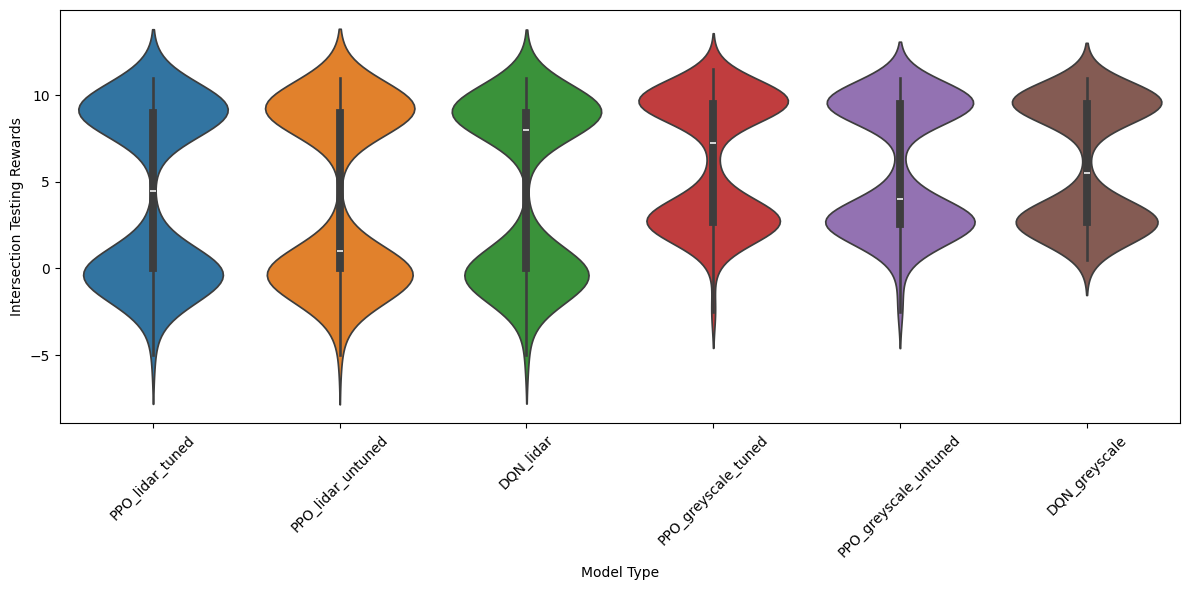

In [32]:
test_df = pd.DataFrame({
    "PPO_lidar_tuned": PPO_lidar_default,
    "PPO_lidar_untuned": PPO_lidar_untuned,
    "DQN_lidar": DQN_lidar_model,
     # divide greyscale rewards by 2 to account for policy frequency of 2
    "PPO_greyscale_tuned": [item/2 for item in PPO_greyscale_default],
    "PPO_greyscale_untuned": [item/2 for item in PPO_greyscale_untuned],
    "DQN_greyscale": [item/2 for item in DQN_greyscale_model]
})


plt.figure(figsize=(12, 6))
sns.violinplot(data=test_df)
plt.xticks(rotation=45)
plt.ylabel("Intersection Testing Rewards")
plt.xlabel("Model Type")
plt.tight_layout()
plt.show()

### Violin plots with scatter

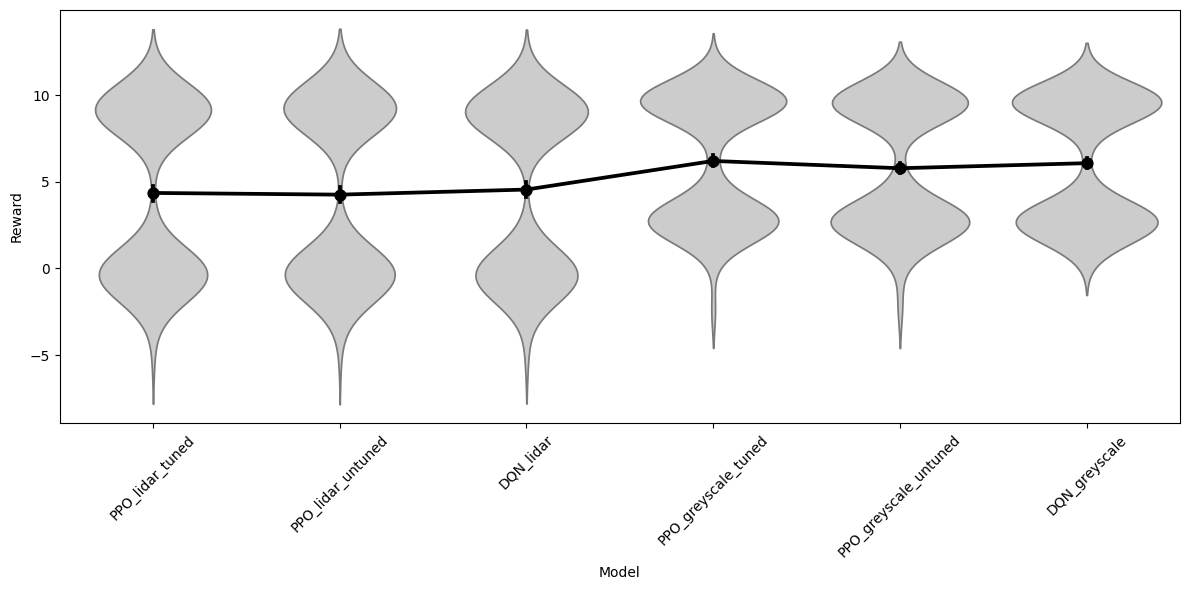

In [33]:
df_long = test_df.melt(var_name="Model", value_name="Reward")

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x="Model", y="Reward", inner=None, color="0.8")
sns.pointplot(data=df_long, x="Model", y="Reward", estimator=np.mean, color="black")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()